In [73]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from pandas import concat, Series


from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [2]:
train_df = pd.read_csv('train_for_2012.csv',index_col=0)
train_df.shape

(837913, 43)

In [3]:
test_df = pd.read_csv('test_for_2012.csv',index_col=0)
test_df.shape

(185639, 43)

In [4]:
# df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [5]:
# modeling_df = df[df['is_first_occurrence']==1].copy()
# print(modeling_df.shape)
# len(modeling_df)/len(df)

In [6]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
train_df.sort_values('stmt_date', inplace=True)

In [7]:
### we'll try dropping NA's for now
train_df.sort_values('stmt_date', inplace=True)

In [8]:
test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
test_df.sort_values('stmt_date', inplace=True)

## Get preprocessing data ready

In [9]:
from preproc_functions import pre_process

In [10]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [11]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {},
    'category_pd': {}
}

In [12]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for roe_quantile


/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature].fillna(0, inplace=True)


Custom bins for net_income_growth_quantile


/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:151: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature].fillna(0, inplace=True)
/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value

In [13]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
roe_quantile


/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:173: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature_name].fillna(0, inplace=True)


net_income_growth_quantile
quick_ratio_v2_quantile


/Users/juanroalvarado/nyu/finance/ml-finance-credit-default/final_harness/preproc_functions.py:173: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[growth_feature_name].fillna(0, inplace=True)


sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile
using training pds for ateco_sector
using training pds for sector_group
using training pds for regional_code
cfo_quantile
using training pds for legal_struct


In [14]:
test_data_proc.columns#.tail(10)

Index(['id', 'stmt_date', 'HQ_city', 'legal_struct', 'ateco_sector',
       'def_date', 'fs_year', 'asst_intang_fixed', 'asst_tang_fixed',
       'asst_fixed_fin', 'asst_current', 'AR', 'cash_and_equiv', 'asst_tot',
       'eqty_tot', 'eqty_corp_family_tot', 'liab_lt', 'liab_lt_emp',
       'debt_bank_st', 'debt_bank_lt', 'debt_fin_st', 'debt_fin_lt', 'AP_st',
       'AP_lt', 'debt_st', 'debt_lt', 'rev_operating', 'COGS',
       'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations',
       'default', 'asst_tot_quantile', 'asst_tot_quantile_values', 'liab_tot',
       'financial_leverage', 'financial_leverage_quantile',
       'financial_leverage_quantile_values', 'profitability_ratio',
       'profitability_ratio_quantile', 'profitability_ratio_quantile_values',
       'roe_quantile', 'roe_quantile_values', 'net_income',
       'net_i

## Train algorithm

In [15]:
### features for first firm
first_features = [
    # 'asst_tot_quantile_values', ####
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    # 'cash_assets_ratio_quantile_values', ####
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda',
    # 'ateco_sector_pd',
    # 'sector_group_pd', ####
    # 'legal_struct_pd',
    'regional_code_pd' ####
]


In [16]:
### features for recurring firms
rec_features = [
    # 'asst_tot_quantile_values', ###
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    # 'cash_assets_ratio_quantile_values',###
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda', ###
    # 'ateco_sector_pd',###
    # 'sector_group_pd',###
    # 'legal_struct_pd',###
    'regional_code_pd'

]

In [17]:
train_data_proc[rec_features].isna().sum()

financial_leverage_quantile_values     0
profitability_ratio_quantile_values    0
net_income_growth_quantile_values      0
quick_ratio_v2_quantile_values         0
sales_growth_quantile_values           0
dscr_quantile_values                   0
roe_quantile_values                    0
cfo_quantile_values                    0
regional_code_pd                       0
dtype: int64

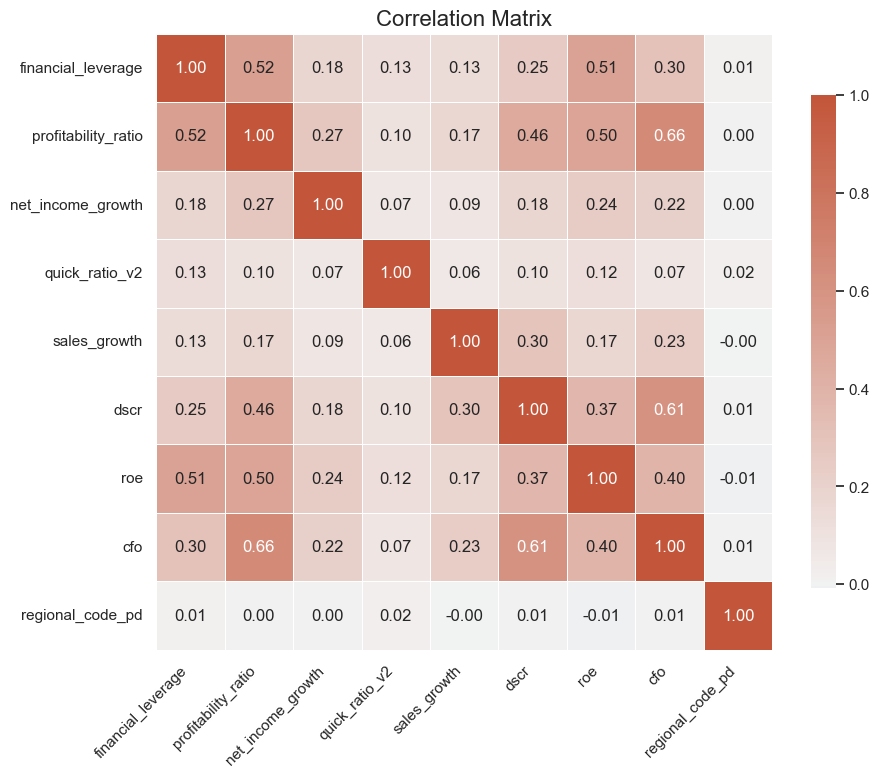

In [18]:
# Compute the correlation matrix
corr = train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap with annotations
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Set title and display the plot
plt.title("Correlation Matrix", fontsize=16)
ticks = [i.split('_quantile_values')[0] for i in corr.index]
ax.set_xticklabels(ticks, rotation=45, ha='right')
ax.set_yticklabels(ticks, rotation=0, va='center')

# plt.xticks(rotation0)
plt.show()


In [19]:
 from statsmodels.stats.outliers_influence import variance_inflation_factor

In [20]:

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_data_proc[rec_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].values, i)
                          for i in range(len(train_data_proc[train_data_proc['is_first_occurrence']==0][rec_features].columns))]

print(vif_data)

                               feature       VIF
0   financial_leverage_quantile_values  1.958945
1  profitability_ratio_quantile_values  2.924271
2    net_income_growth_quantile_values  2.382302
3       quick_ratio_v2_quantile_values  6.382111
4         sales_growth_quantile_values  3.708765
5                 dscr_quantile_values  3.031902
6                  roe_quantile_values  2.259868
7                  cfo_quantile_values  3.493907
8                     regional_code_pd  7.926967


In [21]:

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_data_proc[first_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_data_proc[train_data_proc['is_first_occurrence']==1][first_features].values, i)
                          for i in range(len(train_data_proc[train_data_proc['is_first_occurrence']==1][first_features].columns))]

print(vif_data)

                               feature       VIF
0   financial_leverage_quantile_values  2.008377
1  profitability_ratio_quantile_values  2.708025
2       quick_ratio_v2_quantile_values  6.694022
3                 dscr_quantile_values  2.690375
4                  roe_quantile_values  2.013950
5                  cfo_quantile_values  3.373657
6                     regional_code_pd  6.873759


In [22]:
first_formula = 'default ~ '+' + '.join(first_features)
first_formula

'default ~ financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + dscr_quantile_values + roe_quantile_values + cfo_quantile_values + regional_code_pd'

In [23]:
rec_formula = 'default ~ '+' + '.join(rec_features)
rec_formula

'default ~ financial_leverage_quantile_values + profitability_ratio_quantile_values + net_income_growth_quantile_values + quick_ratio_v2_quantile_values + sales_growth_quantile_values + dscr_quantile_values + roe_quantile_values + cfo_quantile_values + regional_code_pd'

In [24]:
from xgboost import XGBClassifier
from pandas import concat

In [74]:
class SplitModel():
    def __init__(self, params, first_features, rec_features):
        self.first_features = first_features
        self.rec_features = rec_features

        self.params = params
    
    def train(self, data):
        
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        

        self.rec_model = XGBClassifier(**self.params)
        self.first_model = XGBClassifier(**self.params)
        
        self.first_fitted_model = self.first_model.fit(X=first_data[self.first_features], 
                   y=first_data['default'])
        self.rec_fitted_model = self.rec_model.fit(X=rec_data[self.rec_features], 
                   y=rec_data['default'])
        
        print("models fitted")

    def predict(self, data):
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        print('rec data length',len(rec_data))
        print('first data length',len(first_data))
        
        rec_preds = Series(self.rec_fitted_model.predict_proba(rec_data[self.rec_features])[:,1])
        rec_preds.index = rec_data.index
        
        first_preds = Series(self.first_fitted_model.predict_proba(first_data[self.first_features])[:,1])
        first_preds.index = first_data.index

        predictions = concat([rec_preds,first_preds]).reindex(data.index)
        
        return predictions

    # def summary(self):
    #     print('~~~~~ First Time First Model ~~~~~~')
    #     print(self.first_fitted_model.summary())
    #     print(self.first_fitted_model.get_margeff().summary())
    #     print('\n')
    #     print('~~~~~ Recurring First Model ~~~~~~')
    #     print(self.rec_fitted_model.summary())
    #     print(self.rec_fitted_model.get_margeff().summary())
    #     print('\n')

In [75]:
train_data_proc.shape

(837913, 83)

In [76]:
test_data_proc.shape

(185639, 83)

In [77]:
params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0,
            "alpha": 0.1,
            "lambda": .1,
            "n_estimators":250
         }

model = SplitModel(params = params, 
                   first_features=first_features, 
                   rec_features=rec_features)

In [78]:
model.train(train_data_proc)

models fitted


In [79]:
preds = model.predict(train_data_proc)

rec data length 612920
first data length 224993


### Model results

In [58]:
# model.summary()

In [59]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv')
# test_data_proc.to_csv('test_processed_data_for_2012.csv')

## Training metrics

In [60]:
train_preds = model.predict(train_data_proc)

rec data length 612920
first data length 224993


In [61]:
train_results = train_data_proc[['default']].copy()
train_results['predictions'] = train_preds

ROC AUC 0.8595512276987143


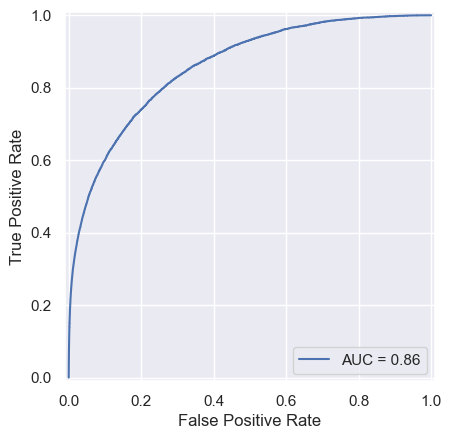

In [62]:
fpr, tpr, thresholds = metrics.roc_curve(train_results['default'], train_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

# hyperparam tuning

In [106]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import roc_auc_score, make_scorer

In [36]:
# param_dist = {
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 200, 300],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.5, 1],
#     'reg_alpha': [0, 0.1, 1, 10],
#     'reg_lambda': [1, 5, 10, 20]
# }
# # param_dist = {
# #         'subsample': 0.6,
# #      'reg_lambda': 10,
# #      'reg_alpha': 10,
# #      'n_estimators': 200,
# #      'min_child_weight': 5,
# #      'max_depth': 9,
# #      'learning_rate': 0.05,
# #      'gamma': 0.1,
# #      'colsample_bytree': 1.0}

# # Create the scorer
# scorer = make_scorer(roc_auc_score, needs_proba=True)

In [110]:
# rec_data_opt = train_data_proc[train_data_proc['is_first_occurrence']==0]

In [112]:
# model = XGBClassifier(n_estimators=100)

In [37]:
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,  # Number of parameter settings to sample
#     scoring=scorer,
#     cv=3,  # 3-fold cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

In [38]:
# random_search.fit(rec_data_opt[rec_features], rec_data_opt['default'])

In [39]:
# results_df = pd.DataFrame(random_search.cv_results_)

# # Sort by the best score in descending order
# sorted_results = results_df.sort_values(by="mean_test_score", ascending=False)

# # Display the top 5 parameter combinations
# print("Top 3 Parameter Combinations:")
# print(sorted_results[['mean_test_score', 'params']].head())

In [40]:
# random_search.best_params_

## Process test data

In [80]:
test_predictions = model.predict(test_data_proc)

rec data length 172921
first data length 12718


In [81]:
test_results = test_data_proc[['default']].copy()
test_results['predictions'] = test_predictions

ROC AUC 0.8666052142535062


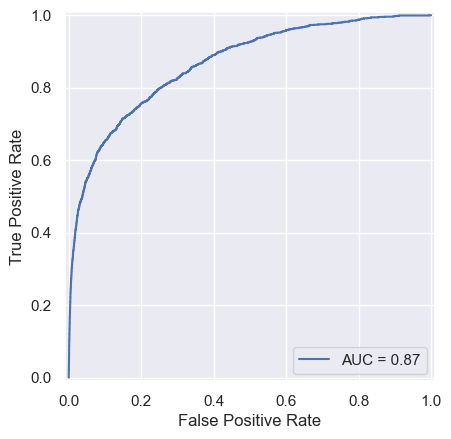

In [82]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [66]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv', index=False)
# test_data_proc.to_csv('test_processed_data_for_2012.csv', index=False)

## saving components for harness

In [67]:
growth_features = [
    'id',
    'stmt_date',
    'net_income',
    'sales'
]

In [68]:
historical_growth = train_data_proc[growth_features]#.to_csv('historical_features.csv')
historical_growth.head()

,id,stmt_date,net_income,sales
Unnamed: 0,,,,
22,520288,2007-12-31,36733.0,2041155.0
18,520288,2008-12-31,-107382.0,967389.0
19,520288,2009-12-31,-77819.0,638687.0
23,520288,2010-12-31,-83593.0,564622.0
17,520288,2011-12-31,-81288.0,538081.0


In [69]:
historical_growth.to_csv('historical_features.csv')

In [70]:
with open('custom_bins.pkl', 'wb') as output:
    pickle.dump(custom_bins, output)

In [71]:
with open('preproc_params.pkl', 'wb') as output:
    pickle.dump(preproc_params, output)

In [72]:
with open('trained_model.pkl', 'wb') as output:
    pickle.dump(model, output)